In [215]:
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import random as rand

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# Overview
***
1. Data Cleaning
2. Benchmark Index
3. Feature Selection
4. Training
5. Evaluation
***

In this notebook I attempt to predict the 1 day ahead price movement of digital assets via a logistic regression using a rolling window of 20 days. The results are mixed with some assets performing well and others exhibiting poor performance. 

In the data cleaning section, I pull in the raw data and clean, organize and reduce the data.  Next, I create an index to evaluate relative performance.  In section 3 I select and transform the features used in the model. The final two sections involve the training and evaluation of the model.

# 1) Data Cleaning
****



### Read Raw Data

In [220]:
#Read raw data
market_data = pd.read_csv('market_data_20180601-20190601.csv')
print("Market data dimensions:",market_data.shape)

#Create a list of assets and evaluate
assets = pd.DataFrame(market_data['base_asset_id'].unique())
orig_assets = assets.copy()
print("# of assets: ",assets.size)

#Add a dates column to the data and verify the number of days
type(market_data['epoch_ts'])
market_data['dates'] = pd.to_datetime(market_data['epoch_ts'])

#Select dates included in the data set and verify # of days
dates = pd.DataFrame(market_data['dates'].unique())
print("# of days: ",dates.size)

#A unique inxed for each asset on each day
market_data.index = market_data['base_asset_id']+"_"+market_data['dates'].dt.strftime('%m/%d/%Y')
market_data = market_data.sort_values(by=['base_asset_id','dates'])
market_data = market_data.set_index('dates',append=True)
print('\nMarket Data:\n')
market_data.head(3)

Market data dimensions: (58326, 17)
# of assets:  186
# of days:  366

Market Data:



,,base_asset_id,quote_asset_id,epoch_ts,price_open,price_high,price_low,price_close,price_mean_a,price_std,price_vwap_a,price_vwap_h,cnt_total,volume_total,volume_high,volume_low,volume_mean_a,volume_std
,dates,,,,,,,,,,,,,,,,,
0x_ZRX_ZRX_06/01/2018,2018-06-01,0x_ZRX_ZRX,USDollar_USD_USD,2018-06-01 00:00:00,1.277573,1.301219,1.229057,1.247135,1.262561,0.015669,1.262384,1.262199,28978,6630317.0,17571.0,1.0,236.721062,553.867218
0x_ZRX_ZRX_06/02/2018,2018-06-02,0x_ZRX_ZRX,USDollar_USD_USD,2018-06-02 00:00:00,1.271138,1.322474,1.247804,1.280419,1.279933,0.015348,1.277636,1.277440,40388,8509672.0,59057.0,1.0,218.201655,704.947500
0x_ZRX_ZRX_06/03/2018,2018-06-03,0x_ZRX_ZRX,USDollar_USD_USD,2018-06-03 00:00:00,1.301020,1.376777,1.295134,1.353140,1.332756,0.018165,1.332982,1.332727,41896,8080548.0,56377.0,1.0,197.924744,623.821686


### Check Missing Values

Give the limited time series I chose only to include assts that had data available for all dates. 

In [221]:

market_data['all_data'] = market_data.iloc[:,3:].isnull().sum(axis=1) # 'all data >0 if any data is missing'
data_check = pd.pivot_table(market_data,values='all_data',index='dates',columns='base_asset_id') #Missing data by asset_id
percent_nan = (data_check.isnull().sum()/dates.count()[0]).sort_values(ascending=False)

print("% of assets missing any data: {0:.0%}".format((percent_nan[percent_nan>0]).count()/assets.count()[0]))
print("% of assets missing at least 25% of data: {0:.0%}".format((percent_nan[percent_nan>.25]).count()/assets.count()[0]))

% of assets missing any data: 56%
% of assets missing at least 25% of data: 20%


Remove assets with any data missing

In [222]:
assets = percent_nan.index[percent_nan==0]
print("Number of assets reduced to ",assets.size, " from ", orig_assets.size)
market_data = market_data[market_data['base_asset_id'].isin(assets)]
print("New data dimensions:",market_data.shape)

Number of assets reduced to  82  from  186
New data dimensions: (30012, 18)


### Check for zero values

In [223]:
zeros = pd.pivot_table(market_data,values='price_close',index='dates',columns='base_asset_id').min().min()
print("Minimum observed colsing price =",zeros)

Minimum observed colsing price = 0.001494373448


None of the 'price_close' values are equal to zero.

### Minimum Volume

To make this model more realistic for institutional use, I exclude assets with a volume level that would take a $5 million fund more than 1 day to liquidate assumng the fund was 1/3 of the volume. 

Text(0.5, 1.0, 'Number of Days To Liquidate ($5 million fund w/ 5% Position Size)')

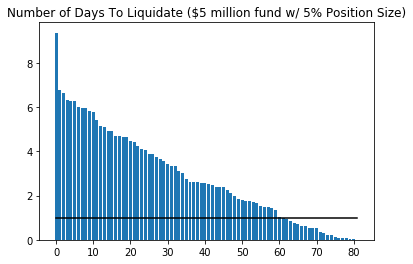

In [224]:
volume_mean = pd.pivot_table(market_data,values='volume_total',index='dates',columns='base_asset_id')
vwap = pd.pivot_table(market_data,values='price_vwap_a',index='dates',columns='base_asset_id')
days_volume = (((5000000*0.2)/((volume_mean*vwap)/3).mean())).sort_values(ascending=False)

plt.bar(range(days_volume.size),days_volume)   
plt.plot(range(days_volume.size),days_volume*0+1, color='black')
plt.title('Number of Days To Liquidate ($5 million fund w/ 5% Position Size)')

Restrict assets to those that would take less than 1 day to liquidate.

In [225]:
assets = days_volume[days_volume<1].index
print("Number of assets reduced to ",assets.size, " from ", orig_assets.size)

Number of assets reduced to  21  from  186


### Evaluate Outliers

In [226]:
price_close = pd.pivot_table(market_data,values='price_close',index='dates',columns='base_asset_id')
price_close_diff = price_close.diff()
price_close_diff_norm = np.abs((price_close_diff-price_close_diff.mean())/price_close_diff.std())
max_diffs = price_close_diff_norm.describe().transpose().sort_values(by='max',ascending=False)[['count','max']]
max_diffs.rename(columns={ 'max' : 'Max Price Std'}, inplace = True)
print("Assets with the largest price deviations")
max_diffs.head(10)

Assets with the largest price deviations


,count,Max Price Std
base_asset_id,,
Enjin_Coin_ENJ_ENJ,365.0,12.768330
Syscoin_SYS_SYS,365.0,12.484481
Skycoin_SKY_SKY,365.0,11.546576
Agrello_DLT_DLT,365.0,9.463340
Groestlcoin_GRS_GRS,365.0,9.420383
Storj_STORJ_STORJ,365.0,9.228169
Viacoin_VIA_VIA,365.0,8.824541
Steem_STEEM_STEEM,365.0,8.777784
Everex_EVX_EVX,365.0,8.757597


#### Evaluate Asset With The Largest Price Deviation 

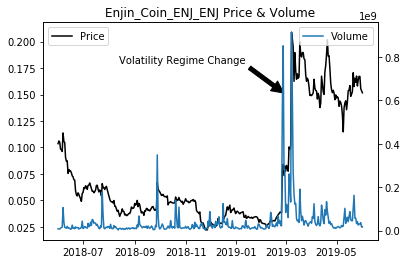

In [228]:
#Select asset with the largest standard deviation
max_diff = market_data[market_data['base_asset_id']==max_diffs.index[0]][['price_close','volume_total']]

fig, ax1 = plt.subplots()
plt.title(max_diffs.index[0]+" Price & Volume")
ax1.plot(max_diff.index.get_level_values('dates'),max_diff['price_close'], color='Black',label='Price')
ax2 = ax1.twinx()
ax2.plot(max_diff.index.get_level_values('dates'),max_diff['volume_total'],label='Volume')
dt = datetime(2019, 3, 1)
ax1.annotate('Volatility Regime Change', xy=(dt, .15), xytext=(dt+timedelta(days=-200), .18),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax1.legend(loc='upper left');ax2.legend()
plt.show()

#### Check daily clustering of price change outliers

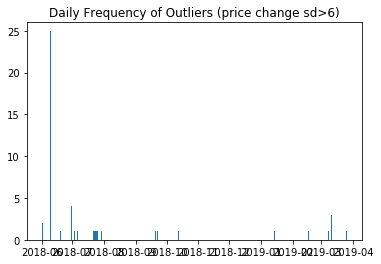

Most outliers occure on Jun 10, 2018


In [229]:
day_diff = ((price_close_diff_norm==price_close_diff_norm.max())&(price_close_diff_norm>6)).sum(axis=1)
day_diff = day_diff[day_diff>0]
plt.bar(day_diff.index,day_diff,width=1)
plt.title('Daily Frequency of Outliers (price change sd>6)')
plt.ylim(0,day_diff.max()+1)
plt.show()
print("Most outliers occure on", day_diff.sort_values(ascending=False).index[0].strftime("%b %d, %Y"))

For now, I am going to leave outliers in the data. The data looks clean overall and very large price spikes are not unusual for crypto currency assets.  

### Add Forward Binary and Log Returns
- fwd_binary is the binary for the next period. 1 of the next day was a psotitve move and 0 if it was negative. This will b eused for model training and testing
- fwd_log_rets is the period ahead log return. This will be used for trading performance evaluation.

In [230]:
market_data['fwd_binary']=np.nan
market_data['fwd_log_rets']=np.nan

market_data['log_rets'] = np.log(market_data['price_close'])
market_data['log_rets'] = market_data.groupby(['base_asset_id'])['log_rets'].diff()
market_data['fwd_log_rets'] = market_data.groupby(['base_asset_id'])['log_rets'].shift(-1)
market_data['binary'] = market_data[market_data['log_rets'].notna()]['log_rets']>0
market_data['fwd_binary'] = market_data.groupby(['base_asset_id'])['binary'].shift(-1)

# 2) Benchmark Index
***

I created a benchmark to evaluate performance versus a simple buy and hold strategy. The benchmark is weighted daily by the log of the average volume. 

In [231]:
rets = pd.pivot_table(market_data,values='price_close',index='dates',columns='base_asset_id').pct_change()
#rets = np.log(pd.pivot_table(market_data,values='price_close',index='dates',columns='base_asset_id')).diff()
volume = np.log(pd.pivot_table(market_data,values='volume_mean_a',index='dates',columns='base_asset_id'))
sums = volume.sum(axis=1)
weights = volume.div(sums,axis=0)

benchmark = pd.DataFrame((1+(rets*weights).sum(axis=1)).cumprod(),columns=['index'])
benchmark['log_rets'] = np.log(benchmark['index']).diff()

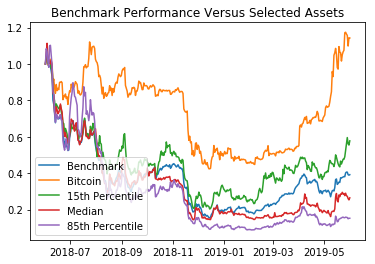

In [232]:
perf = (price_close.tail(1)/price_close.iloc[0,:]).transpose().dropna()
perf = perf.sort_values(by=perf.columns[0],ascending=False)

top_perf = price_close[[perf.index[round(.15*perf.size)]]]
top_perf = top_perf/top_perf.iloc[0,0]

bottom_perf = price_close[[perf.index[round(.85*perf.size)]]]
bottom_perf = bottom_perf/bottom_perf.iloc[0,0]

median_perf = price_close[[perf.index[round(.5*perf.size)]]]
median_perf = median_perf/median_perf.iloc[0,0]

bitcoin = price_close[['Bitcoin_BTC_BTC']]
bitcoin = bitcoin/bitcoin.iloc[0,0]

fig, ax = plt.subplots()
plt.plot(benchmark[['index']],label='Benchmark')
plt.title('Benchmark Performance Versus Selected Assets')
ax.plot(bitcoin,label='Bitcoin')
ax.plot(top_perf,label='15th Percentile')
ax.plot(median_perf,label='Median')
ax.plot(bottom_perf,label='85th Percentile')
ax.legend(loc='lower left')

# 3) Feature Selection
---

Features, 13 total:
- previous 1-5 day's binary perfromance (1=up, 0=down)\n
- The daily log change in total volume
- The 20 day standard deviation of returns
- Parkinson's volatility over 3 and 20 days
- A binary signal for Parkinson's volatility (1 if 3d vol > 20d vol, 0 otherwise)
- Moving Average Binary: 1 if MA3>MA20, 0 otherwise
- Moving Average Binary: 1 if price>MA20, 0 otherwise
- Moving Average Binary: 1 if price>MA3, 0 otherwise

In [233]:
features = market_data[['base_asset_id']]
features.head()

for i in range(5):
    features['prev_binary_'+str(i+1)] = market_data.groupby('base_asset_id')['binary'].shift(i)

features['volume_chg'] = np.log(market_data['volume_total'])
features['volume_chg'] = features.groupby('base_asset_id')['volume_chg'].diff()
features['std'] =  market_data.groupby('base_asset_id')['log_rets'].rolling(20).std().reset_index(0,drop=True)

#Parkinson's Volatility, 1 and 20 day
features['park_vol_3d'] = (1/(4*np.log(2)))*np.square(np.log(market_data['price_high']/market_data['price_low']))
features['park_vol_3d'] = features.groupby('base_asset_id')['park_vol_3d'].rolling(3).mean().reset_index(0,drop=True)
features['park_vol_3d'] = np.sqrt(features['park_vol_3d'])
features['park_vol_20d'] = (1/(4*np.log(2)))*np.square(np.log(market_data['price_high']/market_data['price_low']))
features['park_vol_20d'] = features.groupby('base_asset_id')['park_vol_20d'].rolling(20).mean().reset_index(0,drop=True)
features['park_vol_20d'] = np.sqrt(features['park_vol_20d'])
features['park_vol_signal'] = np.where(features['park_vol_20d'].isnull(),np.nan,features['park_vol_3d']<features['park_vol_20d'])

#Moving average signals
ma_20d = market_data.groupby('base_asset_id')['price_close'].rolling(20).mean().reset_index(0,drop=True)
ma_3d =  market_data.groupby('base_asset_id')['price_close'].rolling(3).mean().reset_index(0,drop=True)
features['ma3_over_ma20'] = np.where(ma_20d.isnull(),np.nan,ma_3d>ma_20d)
features['price_over_ma20'] = np.where(ma_20d.isnull(),np.nan,market_data['price_close']>ma_20d)
features['price_over_ma3'] = np.where(ma_3d.isnull(),np.nan,market_data['price_close']>ma_3d)

data = market_data[['base_asset_id','fwd_log_rets','fwd_binary']].merge(features.iloc[:,1:],left_index=True,right_index=True).dropna()
data[data['base_asset_id']=='Bitcoin_BTC_BTC'].head(3)

,,base_asset_id,fwd_log_rets,fwd_binary,prev_binary_1,prev_binary_2,prev_binary_3,prev_binary_4,prev_binary_5,volume_chg,std,park_vol_3d,park_vol_20d,park_vol_signal,ma3_over_ma20,price_over_ma20,price_over_ma3
,dates,,,,,,,,,,,,,,,,
Bitcoin_BTC_BTC_06/21/2018,2018-06-21,Bitcoin_BTC_BTC,-0.109578,False,False,True,True,True,False,-0.136571,0.036090,0.022087,0.035158,1.0,0.0,0.0,0.0
Bitcoin_BTC_BTC_06/22/2018,2018-06-22,Bitcoin_BTC_BTC,0.024486,True,False,False,True,True,True,0.971193,0.042342,0.053169,0.039787,0.0,0.0,0.0,0.0
Bitcoin_BTC_BTC_06/23/2018,2018-06-23,Bitcoin_BTC_BTC,-0.004272,False,True,False,False,True,True,-0.863386,0.042912,0.053308,0.039906,0.0,0.0,0.0,0.0


### Feature Plots

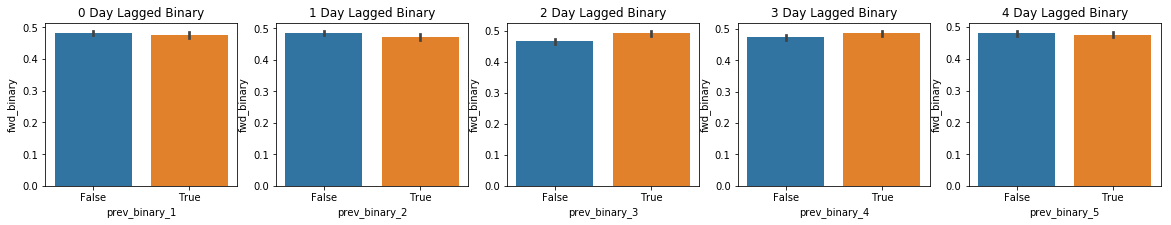

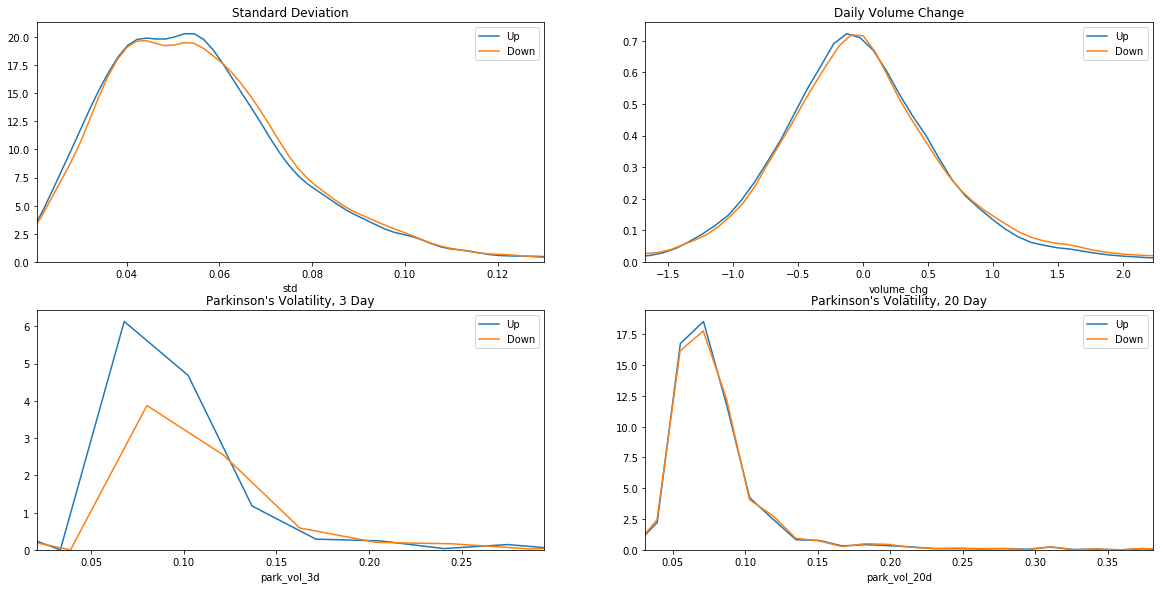

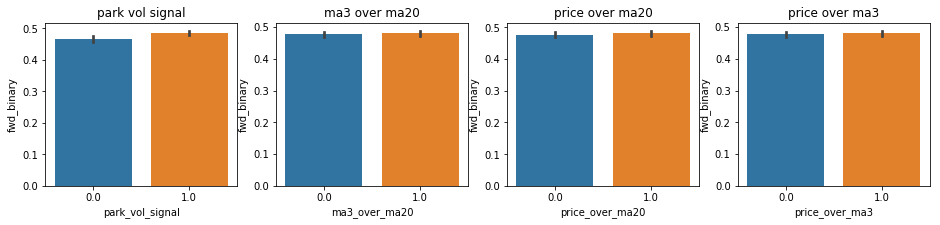

In [199]:
#Prev Binary Plots
plt.figure(figsize=(20,3))
binary_cols = data.columns[3:8]
i=1
for col in binary_cols:
    plt.subplot(1, 5, i)
    sns.barplot(col, 'fwd_binary',data=data)
    plt.title(str(i-1)+' Day Lagged Binary')
    i=i+1
plt.show()

## Bivariate Kernel Density Estimate Plots
def kde_plot(col,title,r,c,i):
        plt.subplot(r, c, i)
        ax = sns.kdeplot(data[col][data.fwd_binary == 1])
        sns.kdeplot(data[col][data.fwd_binary == 0])
        plt.legend(['Up', 'Down'])
        plt.title(title)
        ax.set(xlabel=col)
        plt.xlim(data[col].quantile(.01),data[col].quantile(.99))

plt.figure(figsize=(20,15))
kde_plot('std','Standard Deviation',3,2,1)
kde_plot('volume_chg','Daily Volume Change',3,2,2)
kde_plot('park_vol_3d',"Parkinson's Volatility, 3 Day",3,2,3)
kde_plot('park_vol_20d',"Parkinson's Volatility, 20 Day",3,2,4)
plt.show()

# Remaining binary plots
plt.figure(figsize=(20,3))
binary_cols = data.columns[12:16]
i=1
for col in binary_cols:
    plt.subplot(1, 5, i)
    sns.barplot(col, 'fwd_binary',data=data)
    plt.title(col.replace('_',' '))
    i=i+1
plt.show()

# 4) Training
***

I train a logit regression with a rolling 20 day window. I chose a rolling window due to the limited days of observation and lack of multiple regimes with similar charastics. To keep the time and presentation limited I randomly chose 5 of the remaining assets to train and analyze. 

In [234]:
rand.seed(12)

#Randomly select 5 of the remaining assets
selected_assets = rand.sample(list(assets),5)
print("Selected Assets:\n",selected_assets,"\n")

#Shrind data to only include selected assets. This made the algo slightly faster.
sel_data = data[data['base_asset_id'].isin(selected_assets)]

win_size = 20
cur_dates = sel_data.index.get_level_values('dates').unique()

returns = pd.DataFrame(index=cur_dates[win_size+1:],columns=selected_assets) #Track the test returns by asset
binary = pd.DataFrame(index=cur_dates[win_size+1:],columns=selected_assets) #Trach the test signal by asset

for a in selected_assets: #loop through selected assets
    cur_data = sel_data[sel_data['base_asset_id']==a] #Filter data for only current asset
    X = cur_data.iloc[:,3:] #Features
    y = cur_data['fwd_binary'].astype('int') #Signal
    
    for edate in cur_dates[win_size:-1]: #Loop through dates starting at win_size
        sdate = edate-timedelta(days=win_size)
        ndate = edate+timedelta(days=1)
        dt_range = cur_dates[(cur_dates <= edate) & (cur_dates >= sdate)]    
        
        step_X = X[X.index.get_level_values('dates').isin(dt_range)] # Xs for the window range
        step_y = y[y.index.get_level_values('dates').isin(dt_range)] # Ys for the window range
        model = LogisticRegression().fit(step_X,step_y) #Fit the linear regression

        train_score = (train_pred==step_y).mean() #Score on training data       
        
        nX = X[X.index.get_level_values('dates')==ndate] # 1 day ahead features
        pred = 1 if model.predict(nX) else -1 # 1 day ahead prediction 
        
        nRet = np.nan
        if train_score > 0.55: #Trade only if the training score is greater than 55%
            nRet = cur_data[cur_data.index.get_level_values('dates')==ndate].iloc[0,1]
        returns.loc[edate+timedelta(days=1)][a] = pred*nRet #The forward tested return
        
        nBinary = cur_data[cur_data.index.get_level_values('dates')==ndate].iloc[0,2]
        binary.loc[edate+timedelta(days=1)][a] = int(model.predict(nX)==nBinary)

Selected Assets:
 ['Litecoin_LTC_LTC', 'Nano_NANO_NANO', 'Bitcoin_Cash_BCH_BCH', 'ICON_ICX_ICX', 'Enjin_Coin_ENJ_ENJ'] 



# 5) Results
***

The results were mixed. All assets outperformed the benchmark, but the informtion and sortino ratios were low.

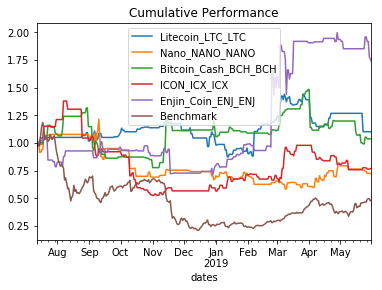

                     Mean Return Return STD Total Return      IC Sortino  \
ICON_ICX_ICX              -0.11%      5.74%      -23.24%  -0.019  -0.068   
Nano_NANO_NANO            -0.21%      5.59%      -27.64%  -0.037  -0.089   
Benchmark                 -0.12%      4.53%      -52.62%  -0.027  -0.019   
Litecoin_LTC_LTC           0.20%      4.63%       10.09%   0.044   0.105   
Bitcoin_Cash_BCH_BCH       0.25%      6.42%        3.67%   0.039   0.131   
Enjin_Coin_ENJ_ENJ         1.05%     10.23%       73.50%   0.103   0.729   

                        Skew Kurtosis % Traded  
ICON_ICX_ICX          -0.192    2.367    0.30%  
Nano_NANO_NANO        -0.280    1.421    0.27%  
Benchmark             -0.885    3.437    1.00%  
Litecoin_LTC_LTC       1.416    9.250    0.29%  
Bitcoin_Cash_BCH_BCH   0.322    6.192    0.24%  
Enjin_Coin_ENJ_ENJ     3.798   26.720    0.27%  


In [235]:
returns['Benchmark'] = benchmark['log_rets'] #Add the benchmark returns

indexed = returns.fillna(value=0) 
indexed = (1+indexed).cumprod() # Create indexed performance

indexed.plot()
plt.title('Cumulative Performance')
plt.show()

results = pd.DataFrame(columns=['Mean Return','Return STD','Total Return','IC','Sortino','Skew','Kurtosis','% Traded'])

results['Mean Return'] = (returns.mean()*100).map('{:,.2f}%'.format)
results['Return STD'] = (returns.std()*100).map('{:,.2f}%'.format)
results['Total Return'] = ((indexed.iloc[-1,:]-1)*100).map('{:,.2f}%'.format)
results['IC'] = (returns.mean()/returns.std()).map('{:,.3f}'.format)
results['% Traded'] = (1-returns.isna().mean()).map('{:,.2f}%'.format)

down_dev = returns.dropna()
down_dev = down_dev[down_dev<0].std()
results['Sortino'] = (returns.mean()/down_dev).map('{:,.3f}'.format)

results['Skew'] = returns.skew().map('{:,.3f}'.format)
results['Kurtosis'] = returns.kurtosis().map('{:,.3f}'.format)

print(results.sort_values(by='Total Return'))

Examining the distribution of Enjin_Coin_ENJ_ENJ to investigate the large kurtosis

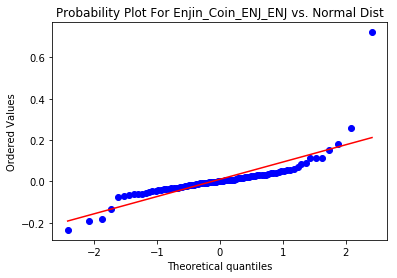

In [236]:
stats.probplot(np.array(returns['Enjin_Coin_ENJ_ENJ'].dropna()).astype('float32'), dist="norm", plot=plt)
plt.title('Probability Plot For Enjin_Coin_ENJ_ENJ vs. Normal Dist')
plt.show()

The Kurtosis number is affected by one very large outlier. 

# Conclusion
***

the results were mixed at best. Although the total return of all the traded assets was larger than the index, the information coeficient and Sortino ratio were pretty low. This is concerning as no trading costs were included and, given the limited time samples, I expect this strategy would show a high degreee of variance when implemented. 